In [3]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation,concatenate,BatchNormalization
from tensorflow.keras.layers import Input, Dense, Flatten, Add,Lambda,LeakyReLU
from tensorflow.keras.optimizers import SGD,Adam,schedules
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D,MaxPooling1D,GlobalMaxPooling1D,SpatialDropout1D
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import constraints
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.initializers import Ones, Zeros

In [4]:
class GroupNormalization(Layer):
	def __init__(self,groups=32,axis=-1,epsilon=1e-5,center=True,scale=True,beta_initializer='zeros',gamma_initializer='ones',beta_regularizer=None,
				 gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,**kwargs):
		super(GroupNormalization, self).__init__(**kwargs)
		self.supports_masking = True
		self.groups = groups
		self.axis = axis
		self.epsilon = epsilon
		self.center = center
		self.scale = scale
		self.beta_initializer = initializers.get(beta_initializer)
		self.gamma_initializer = initializers.get(gamma_initializer)
		self.beta_regularizer = regularizers.get(beta_regularizer)
		self.gamma_regularizer = regularizers.get(gamma_regularizer)
		self.beta_constraint = constraints.get(beta_constraint)
		self.gamma_constraint = constraints.get(gamma_constraint)

	def build(self, input_shape):
		dim = input_shape[self.axis]

		if dim is None:
			raise ValueError('Axis '+str(self.axis)+' of input tensor should have a defined dimension but the layer received an input with shape '+str(input_shape)+'.')

		if dim < self.groups:
			raise ValueError('Number of groups ('+str(self.groups)+') cannot be more than the number of channels ('+str(dim)+').')

		if dim % self.groups != 0:
			raise ValueError('Number of groups ('+str(self.groups)+') must be a multiple of the number of channels ('+str(dim)+').')

		self.input_spec = InputSpec(ndim=len(input_shape),axes={self.axis: dim})
		shape = (dim,)

		if self.scale:
			self.gamma = self.add_weight(shape=shape,name='gamma',initializer=self.gamma_initializer,regularizer=self.gamma_regularizer,constraint=self.gamma_constraint)
		else:
			self.gamma = None

		if self.center:
			self.beta = self.add_weight(shape=shape,name='beta',initializer=self.beta_initializer,regularizer=self.beta_regularizer,constraint=self.beta_constraint)
		else:
			self.beta = None

		self.built = True

	def call(self, inputs, **kwargs):
		input_shape = K.int_shape(inputs)
		tensor_input_shape = K.shape(inputs)

		# Prepare broadcasting shape.
		reduction_axes = list(range(len(input_shape)))
		del reduction_axes[self.axis]
		broadcast_shape = [1] * len(input_shape)
		broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
		broadcast_shape.insert(1, self.groups)

		reshape_group_shape = K.shape(inputs)
		group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
		group_axes[self.axis] = input_shape[self.axis] // self.groups
		group_axes.insert(1, self.groups)

		# reshape inputs to new group shape
		group_shape = [group_axes[0], self.groups] + group_axes[2:]
		group_shape = K.stack(group_shape)
		inputs = K.reshape(inputs, group_shape)

		group_reduction_axes = list(range(len(group_axes)))
		group_reduction_axes = group_reduction_axes[2:]

		mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
		variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)
		inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

		# prepare broadcast shape
		inputs = K.reshape(inputs, group_shape)
		outputs = inputs

		# In this case we must explicitly broadcast all parameters.
		if self.scale:
			broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
			outputs = outputs * broadcast_gamma

		if self.center:
			broadcast_beta = K.reshape(self.beta, broadcast_shape)
			outputs = outputs + broadcast_beta

		outputs = K.reshape(outputs, tensor_input_shape)

		return outputs
    

In [37]:
def CNN(inputs):
    x = Conv1D(filters= 16, kernel_size= 12, padding = 'valid', kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4))(inputs)
    #x = GroupNormalization(groups = 4, axis = -1)(x) 
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size = 12)(x)
    x = Dropout(0.5)(x)
    #x = Conv1D(filters= 32, kernel_size= 12, padding = 'valid', kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4))(x)
    #x = Activation('relu')(x)
    #x = MaxPooling1D(pool_size = 12)(x)
    #x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(32,  kernel_regularizer = regularizers.l2(1e-4),bias_regularizer = regularizers.l2(1e-4))(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    return x

In [38]:
def Regression_CNN(length):

    input_shape1 = (length,1)
    cov_input = Input(shape = input_shape1,name="cov_input")
    input_layers = cov_input

    x = CNN(cov_input)
    outLayer= Dense(1, activation='linear')(x)

    model = Model(inputs=input_layers, outputs=outLayer)

    return model


In [39]:
LENGTH = 1001

In [8]:
model = Regression_CNN(LENGTH)

In [9]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cov_input (InputLayer)       [(None, 1001, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 990, 16)           208       
_________________________________________________________________
group_normalization (GroupNo (None, 990, 16)           32        
_________________________________________________________________
activation (Activation)      (None, 990, 16)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 82, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 82, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1312)              0     

In [1]:
from prep_data_regression import prep_data,DataGenerator,EvaDataGenerator,get_data

In [2]:
train_data,train_labels,train_id,valid_data,valid_labels,valid_id = prep_data('coverage_data/Finetune.thle2_control.usage.txt',5)

Size of dataset: 11347


In [10]:
np.min(train_data)

0.0

In [10]:
def normalization(train_data,train_labels,valid_data,valid_labels):
    train_data = np.log(train_data+0.01)
    train_labels = np.log(train_labels)
    valid_data = np.log(valid_data+0.01)
    valid_labels = np.log(valid_labels)
    data_mean = np.mean(train_data)
    data_std  = np.std(train_data)
    label_mean = np.mean(train_labels)
    label_std  = np.std(train_labels)
    
    data_max = np.max(train_data)
    
    train_data = (train_data-data_mean)/data_std
    #train_data = train_data/data_max
    #train_data  = train_data/300
    train_labels = (train_labels-label_mean)/label_std
    
    
    
    
    valid_data  = (valid_data-data_mean)/data_std
    #valid_data    = valid_data/data_max
    #valid_data  = valid_data/300
    valid_labels = (valid_labels-label_mean)/label_std
    
    
    return data_mean,data_std,data_max,label_mean,label_std,train_data,train_labels,valid_data,valid_labels
    

In [11]:
data_mean,data_std,data_max,label_mean,label_std, train_x,train_y,valid_x,valid_y = normalization(train_data,train_labels,valid_data,valid_labels)

In [12]:
print(data_mean,data_std)
print(label_mean,label_std)

-2.1986308 2.1509533
4.735769 1.5976931


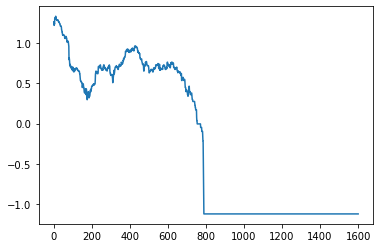

In [13]:
plt.plot(range(train_x.shape[1]),train_x[5,:,0])

In [14]:
training_generator =  DataGenerator(train_x,train_y,train_id,16,LENGTH)
validation_generator = DataGenerator(valid_x,valid_y,valid_id,0,LENGTH)

In [15]:
a,b= next(iter(training_generator))

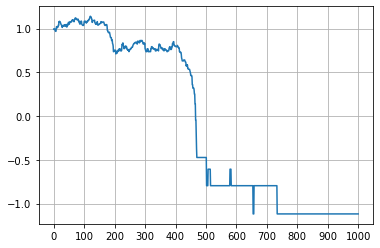

In [16]:
plt.plot(range(LENGTH),a[9])
plt.xticks(np.arange(0, LENGTH, 100))
plt.grid()
plt.show()

In [17]:
lr_schedule = schedules.ExponentialDecay(5e-4,decay_steps=5000,decay_rate=0.96)
#model.compile(loss='mean_squared_logarithmic_error', optimizer= SGD(momentum = 0.98, learning_rate = lr_schedule), metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer= SGD(momentum = 0.98, learning_rate = lr_schedule), metrics=['mse'])

In [18]:
trainid='thle2.mle.linear'
checkpoint_path = "Regression_Model/"+trainid+"-{epoch:04d}.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,period=10)

In [20]:
 history = model.fit(training_generator,epochs=2000,validation_data=validation_generator,callbacks=[cp_callback])

Train for 283 steps, validate for 70 steps
Epoch 1/2000
283/283 [==============================] - 3s 11ms/step - loss: 1.0052 - mse: 0.9980 - val_loss: 0.8175 - val_mse: 0.8100
Epoch 2/2000
283/283 [==============================] - 1s 5ms/step - loss: 0.8909 - mse: 0.8835 - val_loss: 0.7569 - val_mse: 0.7494
Epoch 3/2000
283/283 [==============================] - 1s 5ms/step - loss: 0.8284 - mse: 0.8209 - val_loss: 0.7325 - val_mse: 0.7250
Epoch 4/2000
283/283 [==============================] - 1s 5ms/step - loss: 0.7946 - mse: 0.7871 - val_loss: 0.6522 - val_mse: 0.6446
Epoch 5/2000
283/283 [==============================] - 1s 5ms/step - loss: 0.7608 - mse: 0.7533 - val_loss: 0.6832 - val_mse: 0.6757
Epoch 6/2000
283/283 [==============================] - 1s 5ms/step - loss: 0.7498 - mse: 0.7423 - val_loss: 0.6465 - val_mse: 0.6390
Epoch 7/2000
283/283 [==============================] - 1s 5ms/step - loss: 0.7586 - mse: 0.7511 - val_loss: 0.6958 - val_mse: 0.6883
Epoch 8/2000
283/2

In [21]:
for key in history.history.keys():
    print(key)

loss
mse
val_loss
val_mse


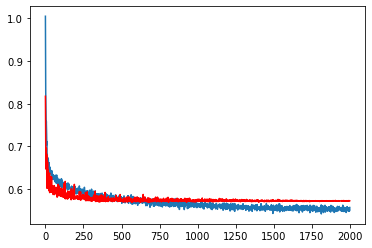

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Loss of training data')
plt.plot(history.history['val_loss'], color='red', label='Loss of validation data')

In [24]:
def evaluate(x,y,pasid,trainid,dataset,label_mean,label_std,bestEpoch=1990):
    test_generator = EvaDataGenerator(x,LENGTH)
    model = Regression_CNN(LENGTH)
    MODEL_PATH = 'Regression_Model/'+trainid+'-'+str(bestEpoch)+'.ckpt'
    model.load_weights(MODEL_PATH)
    print('load weight success')
    pred = model.predict_generator(test_generator)
    OUT=open(dataset+'.'+trainid,'w')
    OUT.write("pas_id\tpredict\tpolyA\tpredict_readCount\tpolyA_readCount\n")
    for i in range(len(pred)):
        predict = pred[i][0]
        predict_readCount = np.exp(predict*label_std+label_mean)
        truth = y[i]
        truth_readCount   = np.exp(truth*label_std+label_mean)
        OUT.write('%s\t%s\t%s\t%s\t%s\n'%(pasid[i],predict,truth,predict_readCount,truth_readCount))
    OUT.close()

In [20]:
testid='thle2.mle.linear'
evaluate(train_x,train_y,train_id,testid,'train',label_mean,label_std)

load weight success


In [21]:
evaluate(valid_x,valid_y,valid_id,testid,'valid',label_mean,label_std)

load weight success


In [51]:
#train_data,train_labels,train_pasid,valid_data,valid_labels,valid_pasid = prep_data('coverage_data/thle2_control.pAs.usage.txt',5)
train_data,train_labels,train_pasid,valid_data,valid_labels,valid_pasid = prep_data('coverage_data/Finetune.thle2_control.usage.txt',5)
data_mean,data_std,data_max,label_mean,label_std, train_x,train_y,valid_x,valid_y = normalization(train_data,train_labels,valid_data,valid_labels)

Size of dataset: 11408


In [56]:
LENGTH=1001
testid='Regression.p1.f_thle2.shift16'
bestEpoch = '1600'
evaluate(train_x,train_y,train_pasid,testid,'train',label_mean,label_std,bestEpoch)
evaluate(valid_x,valid_y,valid_pasid,testid,'valid',label_mean,label_std,bestEpoch)

load weight success
load weight success


In [ ]:
test_generator = DataGenerator(train_x,train_y,0,shuffle=False)

In [ ]:
data1,labels,pasid = get_data('usage_data/BL6_REP1.pAs.predict.coverage.txt')

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5,random_state=len(labels)+1,shuffle=True)

In [ ]:
folds = list(kf.split(labels))
train_index,valid_index = folds[0]

In [ ]:
OUT=open('test','w')
OUT.write("RNA_readCount\n")
for coverage in valid_data:
    mean = np.mean(coverage)
    OUT.write('%s\n'%(mean))
    #for i in coverage:
     #   OUT.write('%s\n'%(i[0]))
OUT.close()

In [ ]:
train_data[0][0]

In [ ]:
np.min(train_x)